Total Nr of Images in the dataset: 100
Image Metadata:
     FileName  Width  Height  Aspect Ratio
husky_34.jpeg    640     480          1.33
 husky_1.jpeg    640     480          1.33
 wolf_10.jpeg   2048    1368          1.50
husky_22.jpeg    500     375          1.33
 wolf_47.jpeg    720     480          1.50
  wolf_8.jpeg   1068     712          1.50
husky_18.jpeg    640     627          1.02
husky_38.jpeg    500     409          1.22
 wolf_30.jpeg   1024     819          1.25
  wolf_4.jpeg    680    1024          0.66
husky_14.jpeg    500     333          1.50
husky_43.jpeg    500     375          1.33
 wolf_26.jpeg   1024     680          1.51
husky_42.jpeg    500     375          1.33
 wolf_27.jpeg   1024     683          1.50
husky_15.jpeg    640     480          1.33
  wolf_5.jpeg    720     480          1.50
 wolf_31.jpeg   1024     819          1.25
husky_39.jpeg    500     357          1.40
husky_19.jpeg    640     480          1.33
  wolf_9.jpeg    769     480          1.60

Text(0, 0.5, 'Height')

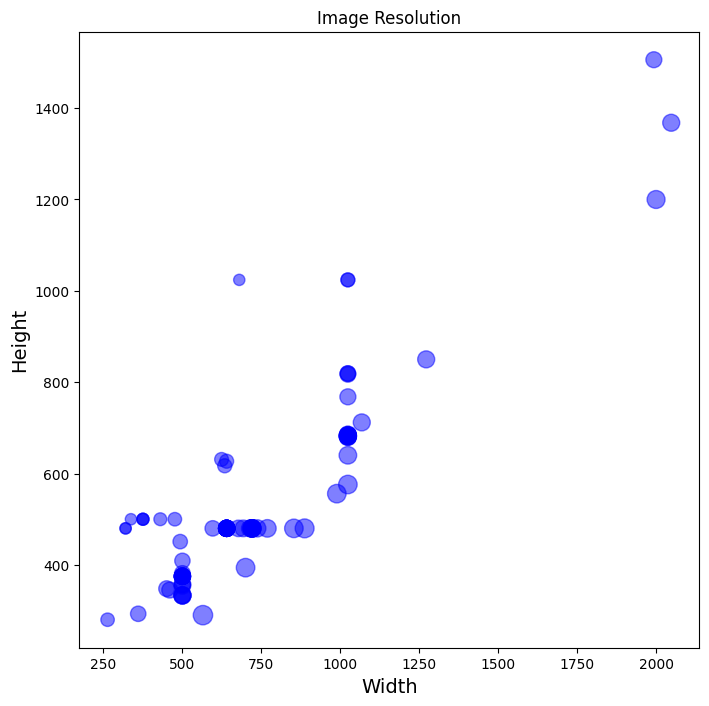

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np

root = "data2/"

# Get the Image Resolutions
imgs = [img.name for img in Path(root).iterdir() if img.suffix == ".jpeg"]
img_meta = {}
for img in imgs:
    img_meta[img] = imagesize.get(Path(root) / img)

img_meta_df = pd.DataFrame.from_dict(img_meta, orient='index', columns=['Width', 'Height']).reset_index()
img_meta_df.rename(columns={'index': 'FileName'}, inplace=True)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
img_meta_df.head()
print("Image Metadata:")
print(img_meta_df.to_string(index=False))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, color='blue', alpha=0.5, s=img_meta_df["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14)


In [2]:
import random
from torchvision import transforms


class RandomTransform:
    def __init__(self, transforms_list, weigts=None):
        self.transforms_list = transforms_list
        self.weights = weigts if weigts is not None else [1/len(transforms_list)] * len(transforms_list)

    def __call__(self, img):
        transform = random.choices(self.transforms_list, weights=self.weights, k=1)[0]
        return transform(img)


class CustomTransforms:
    def __init__(self, width=224, height=224):
        self.width = width
        self.height = height

    def resize(self):
        return transforms.Compose([
                    transforms.Resize((self.width, self.height)),
                    transforms.ToTensor(),
                ])

    def horizontal_flip(self):
        return transforms.Compose([
                    transforms.Resize((self.width, self.height)),
                    transforms.ToTensor(),
                    transforms.RandomHorizontalFlip(),
                ])

    def vertical_flip(self):
        return transforms.Compose([
                    transforms.Resize((self.width, self.height)),
                    transforms.ToTensor(),
                    transforms.RandomVerticalFlip(p=1),
                ])

    def random_rotation(self, degrees=30):
        return transforms.Compose([
                    transforms.Resize((self.width, self.height)),
                    transforms.ToTensor(),
                    transforms.RandomRotation(degrees),
                ])

    def color_jitter(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        return transforms.Compose([
                    transforms.Resize((self.width, self.height)),
                    transforms.ToTensor(),
                    transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue),
                ])

    def random_crop(self, scale=(0.8, 1.0)):
        return transforms.Compose([
                    transforms.RandomResizedCrop(size=(self.width, self.height), scale=scale),
                    transforms.ToTensor(),
                ])

    def grey_scale(self):
        return transforms.Compose([
                    transforms.Resize((self.width, self.height)),
                    transforms.ToTensor(),
                    transforms.RandomGrayscale(p=1),
                ])

In [3]:
IMG_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 14

In [6]:
import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets

def check_data_structure(data_path):
    categories = ["husky", "wolf"]
    for category in categories:
        path = os.path.join(data_path, "train", category)
        if not os.path.exists(path):
            print(f"Error: The directory '{path}' does not exist.")
            return False
        files = os.listdir(path)
        print(f"Found {len(files)} images in '{path}'")
    return True

data_path = "data/"
if not check_data_structure(data_path):
    print("Dataset structure is incorrect. Please check the file paths.")

Found 50 images in 'data/train/husky'
Found 50 images in 'data/train/wolf'


In [9]:


original_dataset = datasets.ImageFolder(root=os.path.join(data_path, "train"))
train_size = int(0.8 * len(original_dataset))
val_size = len(original_dataset) - train_size
train_dataset, val_dataset = random_split(original_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
CT = CustomTransforms(width=IMG_SIZE, height=IMG_SIZE)
transforms_list = [
    t for t in [
        CT.horizontal_flip(),
        CT.random_rotation(30),
        CT.color_jitter(0.5, 0.5, 0.5, 0.5),
        CT.random_crop((0.8, 1.0)),
        CT.vertical_flip(),
        CT.grey_scale()
    ]
]